## 02 Data Preprocessing

This script conducts all preprocessing and merging for all later analysis. It takes in data from \data and creates the final dataset.

In [1]:
# library
import pandas as pd
import numpy as np

#plotting 
from plotnine import *


### Merging Data

In [2]:
#reading in files
nyt = pd.read_csv("../data/nyt_results.csv")
nyp = pd.read_csv("../data/nyp_results.csv")
nydn = pd.read_csv("../data/nydn_results.csv")
chalkbeat = pd.read_csv("../data/chalkbeat_results.csv")
amny = pd.read_csv("../data/amny_results.csv")
spectrum = pd.read_csv("../data/spectrum_results.csv")
brooklyn = pd.read_csv("../data/brooklyn_results.csv")
gotham = pd.read_csv("../data/gotham_results.csv")
queens = pd.read_csv("../data/queens_results.csv")
city = pd.read_csv("../data/cityjournal_results.csv")
nyamsterdam = pd.read_csv("../data/nyamsterdam_results.csv")

In [3]:
#add source column
nyt["source"] = "NY Times"
nyp["source"] = "NY Post"
nydn["source"] = "NY Daily News"
chalkbeat["source"] = "Chalkbeat"
amny["source"] = "AMNY"
spectrum["source"] = "Spectrum NY"
brooklyn["source"] = "Brooklyn Daily Eagle"
gotham["source"] = "Gotham Gazette"
queens["source"] = "Queens Chronicle"
nyamsterdam["source"] = "NY Amsterdam News"
city["source"] = "City Journal"

In [4]:
#extracting year when possible
nyt["year"] = nyt["date_published"].str[0:4]
nyp["year"] = [date.split(",")[1].split(" ")[1] for date in nyp["date_published"].tolist()]
nydn["year"] = nydn["date_published"].str[0:4]
chalkbeat["year"] = chalkbeat["date_published"].str[-4:]
#amny["year"] = amny["date_published"].str[-4:]
amny["year"] = [year if not pd.isna(year) else link.split(".com/")[1].split("/")[0]for year, link in zip(amny["date_published"].str[-4:], amny["link"])]
spectrum["year"] = spectrum["date_published"][0][-19:][6:10]
gotham["year"] = [date[-4:] if len(date) == 12 or len(date) == 11 else np.nan for date in [date.split(" ...")[0] for date in gotham["date_published"].tolist()]]
brooklyn["year"] = [np.nan if pd.isna(date) else date[:4] for date in [ np.nan if pd.isna(date) or "/articles/" not in date else date.split("/articles/")[1] for date in brooklyn["link"].tolist()]]
queens["year"] = queens["date_published"].str[0:4]
city["year"] = city["date_published"].str[-4:]
nyamsterdam["year"] = nyamsterdam["date_published"].str[0:4]

In [5]:
#remove filler snippets for Gotham
gotham["snippet"] = np.where(gotham["snippet"].str.contains("Gotham Gazette is an online publication covering New York policy and politics as well as news on public safety, transportation"), None, gotham["snippet"])

In [6]:
#merge files
df = pd.concat([nyt, nyp, nydn, amny, chalkbeat, spectrum, brooklyn, gotham, queens, nyamsterdam, city]).drop_duplicates().drop(columns=["author", "date_published"])

In [7]:
#merge headline and snippet
df["full_text"] = df["headline"] + " " + df["snippet"]

In [8]:
#check number of rows
df.shape

(1016, 6)

In [9]:
#remove rows with NA headline and year
df = df.dropna(subset = "full_text").dropna(subset = "year")

In [10]:
#check number of rows
df.shape

(849, 6)

In [11]:
df["year"].astype(int)

0     2024
1     2025
2     2025
3     2025
4     2025
      ... 
13    2020
14    2020
15    2019
16    2014
17    2014
Name: year, Length: 849, dtype: int64

In [12]:
#add textid and post2018
df = (
    df.
    reset_index(drop = True).
    assign(
        post2018 = np.where(df["year"].astype(int)> 2017, True, False)
    ).
    reset_index(names = "text_id")
)

### Exploratory Data Analysis

In [13]:
df["source"].value_counts().reset_index()

,source,count
0,NY Times,252
1,NY Daily News,128
2,Chalkbeat,119
3,NY Post,109
4,Queens Chronicle,105
5,Spectrum NY,55
6,NY Amsterdam News,51
7,City Journal,18
8,Gotham Gazette,12


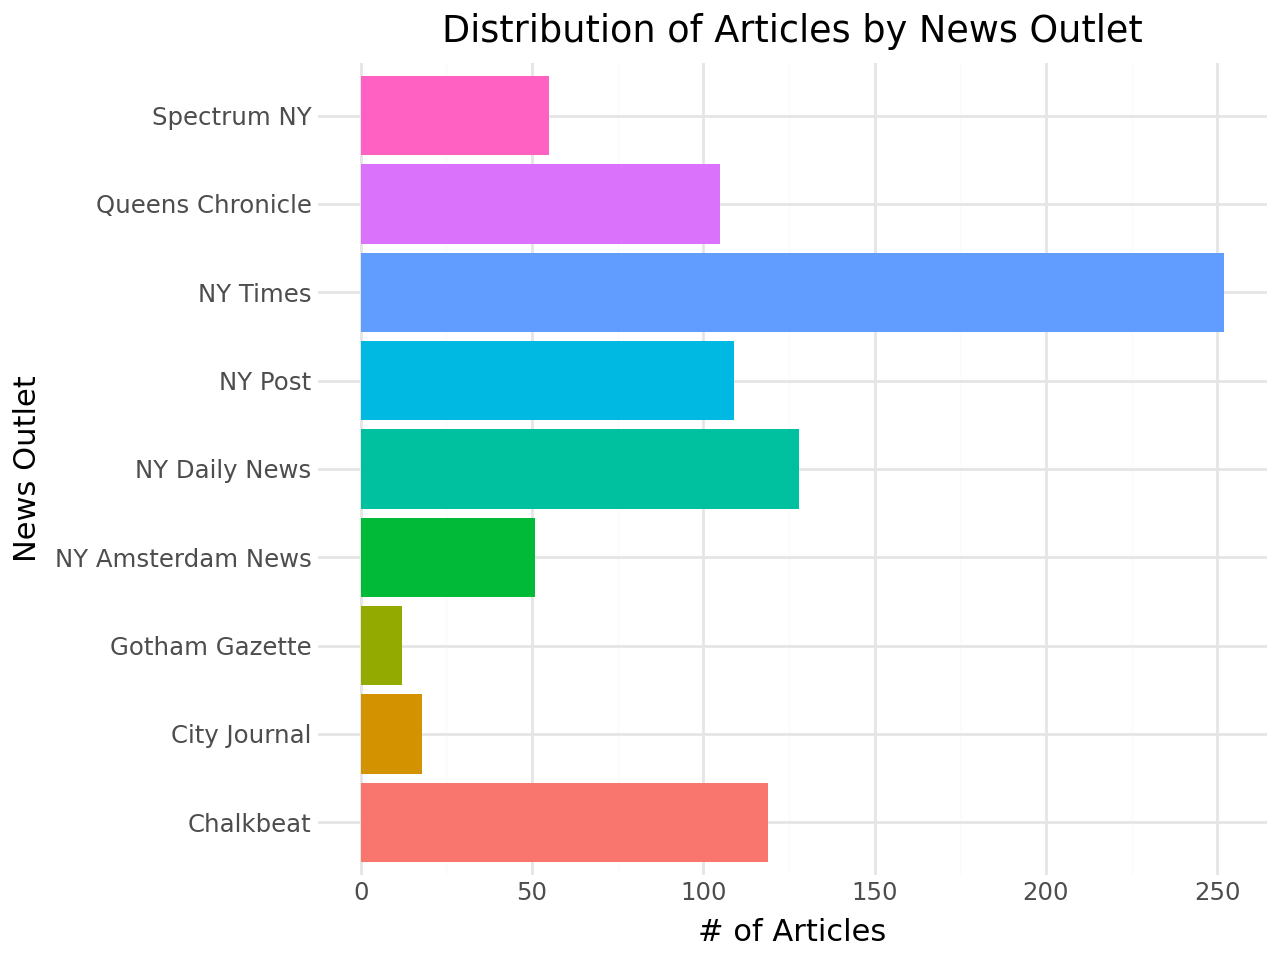

In [14]:
(
    ggplot(df["source"].value_counts().reset_index(),
           aes(x = "source", y = "count", fill = "source")) +
    geom_col() +
    coord_flip() +
    theme_minimal() +
    labs(
        x = "News Outlet",
        y = "# of Articles",
        title = "Distribution of Articles by News Outlet"
    ) +
    theme(
        legend_position = "none"
    )
)

In [15]:
df["year"].value_counts().reset_index().sort_values(by = "year")

,year,count
15,2010,1
14,2011,4
9,2012,27
12,2013,16
7,2014,41
13,2015,14
11,2016,18
10,2017,21
1,2018,154
0,2019,174


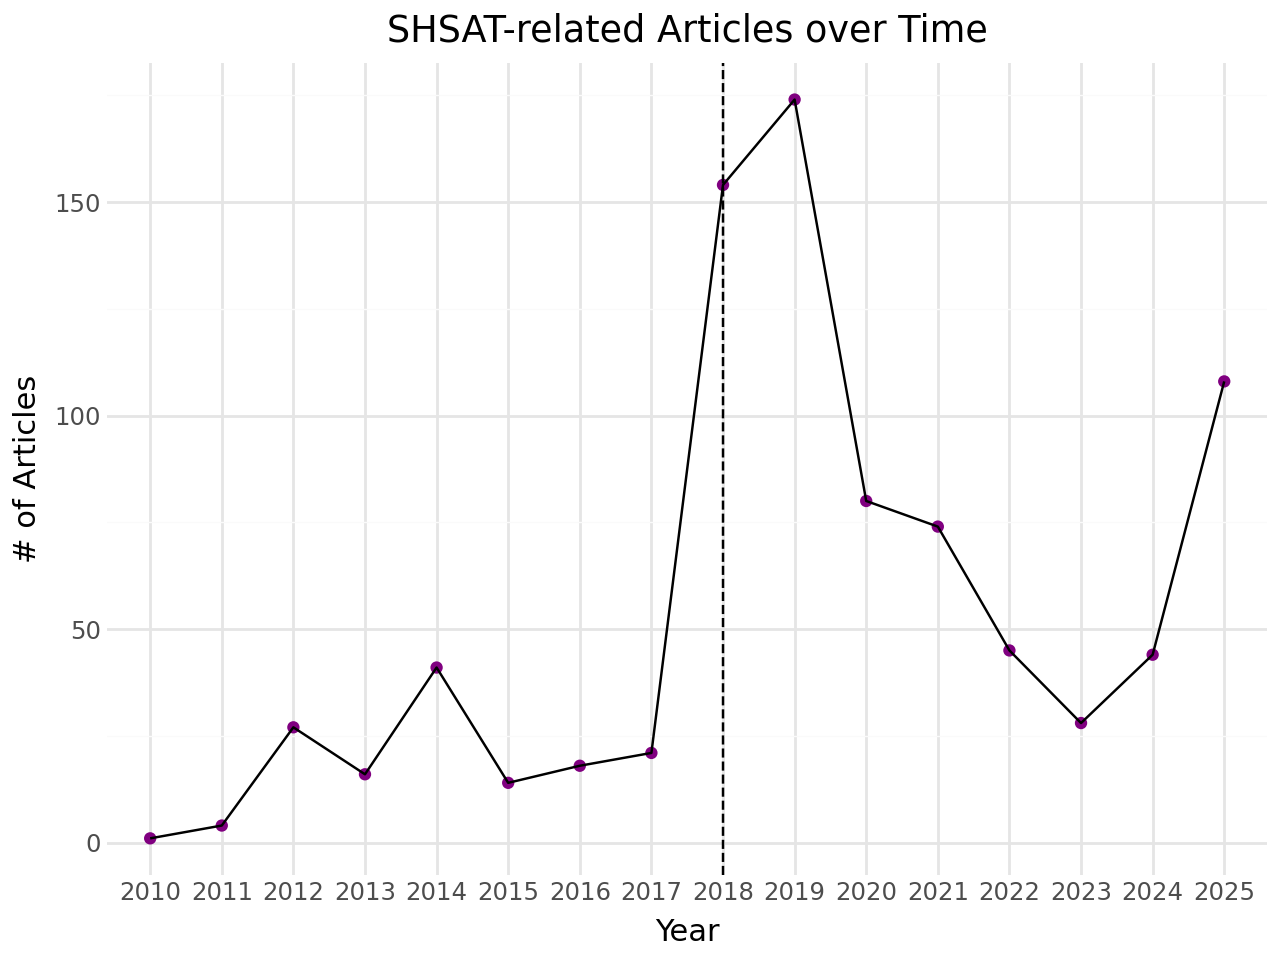

In [16]:
(
    ggplot(df["year"].value_counts().reset_index(),
           aes(x = "year", y = "count", group = 1)) +
    geom_point(color = "purple") +
    geom_line() +
    theme_minimal() +
    labs(
        x = "Year",
        y = "# of Articles",
        title = "SHSAT-related Articles over Time"
    ) +
    geom_vline(xintercept = "2018", linetype = "dashed")
)

In [17]:
#adding meta data (mayors)
terms = [float("-inf"), 2013, 2021, float("inf")]
mayors = ["Michael Bloomberg", "Bill de Blasio", "Eric Adams"]

df["year"] = pd.to_numeric(df["year"], errors = "coerce")
df["mayor"] = pd.cut(df["year"], bins = terms, labels = mayors)
df["year"] = pd.to_datetime(df["year"], format = "%Y", errors = "coerce")

### Exporting

In [18]:
df.to_csv("../data/scraping_results.csv", index = False)